<a href="https://colab.research.google.com/github/Srijani-Das07/Plant-Disease-Detection-and-Classification-Baseline-Models/blob/main/Basic_CNN_%2B_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
abdallahalidev_plantvillage_dataset_path = kagglehub.dataset_download('abdallahalidev/plantvillage-dataset')

print('Data source import complete.')


In [ ]:
import tensorflow as tf

# List physical devices
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
if gpus:
    print("TensorFlow is using GPU ✅")
    print(gpus[0])
else:
    print("No GPU detected ❌")

Num GPUs Available: 1
TensorFlow is using GPU ✅
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# Imports
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import numpy as np
import os

In [ ]:
import kagglehub
dataset_path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")
dataset_path = os.path.join(dataset_path, "color")

In [ ]:
# Prepare dataset
class_names = sorted(os.listdir(dataset_path))
all_image_paths = []
all_labels = []

for class_index, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_image_paths.append(os.path.join(class_dir, fname))
                all_labels.append(class_index)

In [ ]:
# Train/Val/Test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42)

In [ ]:
# Preprocessing
IMG_SIZE = 224
BATCH_SIZE = 16

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    image = data_augmentation(image)
    return image, label

def prepare_dataset(paths, labels, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = prepare_dataset(train_paths, train_labels)
val_ds = prepare_dataset(val_paths, val_labels, shuffle=False)
test_ds = prepare_dataset(test_paths, test_labels, shuffle=False)

I0000 00:00:1750326474.970043      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define image size and class names
IMG_SIZE = 224  # or whatever your image size is
# class_names = [...]  # Ensure this is defined somewhere

# Define the CNN branch
def create_cnn_branch(inputs):
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    return x

# CNN-only model
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
cnn_features = create_cnn_branch(inputs)

x = layers.Dense(512, activation='relu')(cnn_features)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 38)                  │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 303,462 (1.16 MB)

 Trainable params: 301,926 (1.15 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
# 11. Checkpointing

checkpoint_path = "/kaggle/working/model_checkpoint_cnn.h5"
epoch_file_path = "/kaggle/working/last_epoch_cnn.txt"

class EpochCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, epoch_file_path):
        super().__init__()
        self.epoch_file_path = epoch_file_path

    def on_epoch_end(self, epoch, logs=None):
        with open(self.epoch_file_path, 'w') as f:
            f.write(str(epoch + 1))
        print(f"Epoch {epoch+1} completed. Val loss: {logs.get('val_loss')}, Val acc: {logs.get('val_accuracy')}")

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
epoch_checkpoint = EpochCheckpoint(epoch_file_path)

In [ ]:
# 12. Resume if available
if os.path.exists(epoch_file_path):
    with open(epoch_file_path, 'r') as f:
        last_epoch_completed = int(f.read())
    print(f"Resuming training from epoch {last_epoch_completed}")
else:
    last_epoch_completed = 0
    print("Starting training from scratch")

if os.path.exists(checkpoint_path):
    model = load_model(checkpoint_path, custom_objects={'KerasLayer': hub.KerasLayer})
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
else:
    print("Checkpoint not found, using freshly defined model.")

# 13. Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    initial_epoch=last_epoch_completed,
    callbacks=[early_stop, checkpoint_cb, epoch_checkpoint],
    verbose=1
)

Starting training from scratch
Checkpoint not found, using freshly defined model.
Epoch 1/10


I0000 00:00:1750326513.533773      94 service.cc:148] XLA service 0x792e80003e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750326513.534623      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750326513.993745      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/2173 ━━━━━━━━━━━━━━━━━━━━ 1:48 50ms/step - accuracy: 0.0625 - loss: 4.4755  

I0000 00:00:1750326517.906409      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2173/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2716 - loss: 2.9320
Epoch 1: val_loss improved from inf to 1.37996, saving model to /kaggle/working/model_checkpoint_cnn_leaftam.h5
Epoch 1 completed. Val loss: 1.3799582719802856, Val acc: 0.6114627718925476
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 229s 99ms/step - accuracy: 0.2716 - loss: 2.9317 - val_accuracy: 0.6115 - val_loss: 1.3800
Epoch 2/10
2170/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5472 - loss: 1.5954
Epoch 2: val_loss improved from 1.37996 to 1.14170, saving model to /kaggle/working/model_checkpoint_cnn_leaftam.h5
Epoch 2 completed. Val loss: 1.1417025327682495, Val acc: 0.6699274778366089
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 192s 86ms/step - accuracy: 0.5472 - loss: 1.5952 - val_accuracy: 0.6699 - val_loss: 1.1417
Epoch 3/10
2169/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6401 - loss: 1.2371
Epoch 3: val_loss improved from 1.14170 to 0.91492, saving model to /kaggle/working/model_checkpoint_cnn_leaftam.h5
Ep

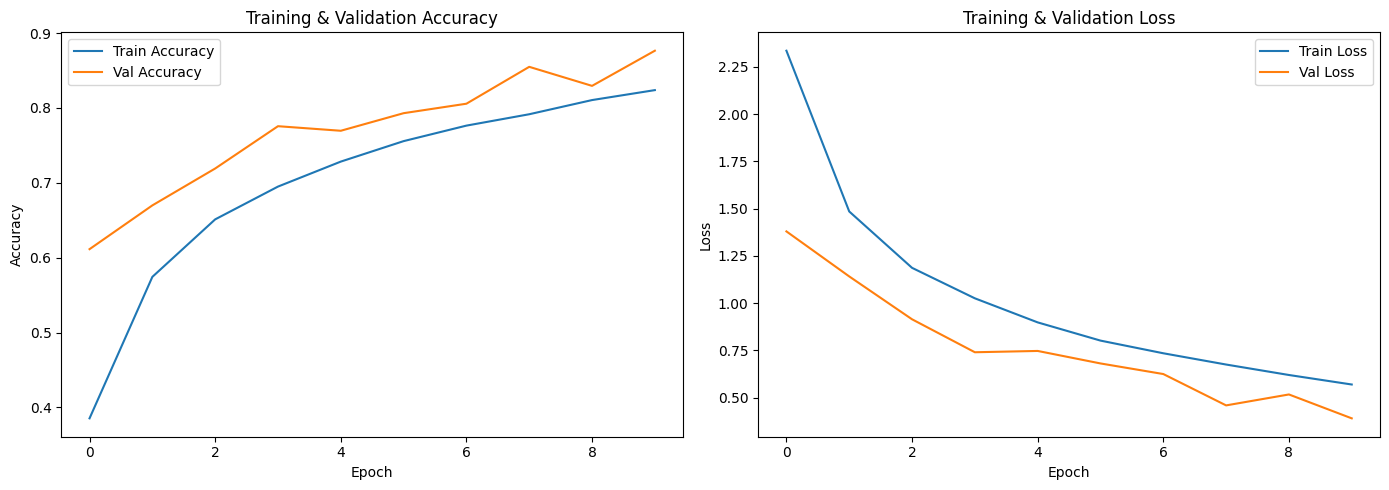

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy/loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_ds)

print(f" Test Accuracy: {test_accuracy * 100:.2f}%")
print(f" Test Loss: {test_loss * 100:.2f}%")

679/679 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - accuracy: 0.8800 - loss: 0.3937
 Test Accuracy: 87.97%
 Test Loss: 38.37%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

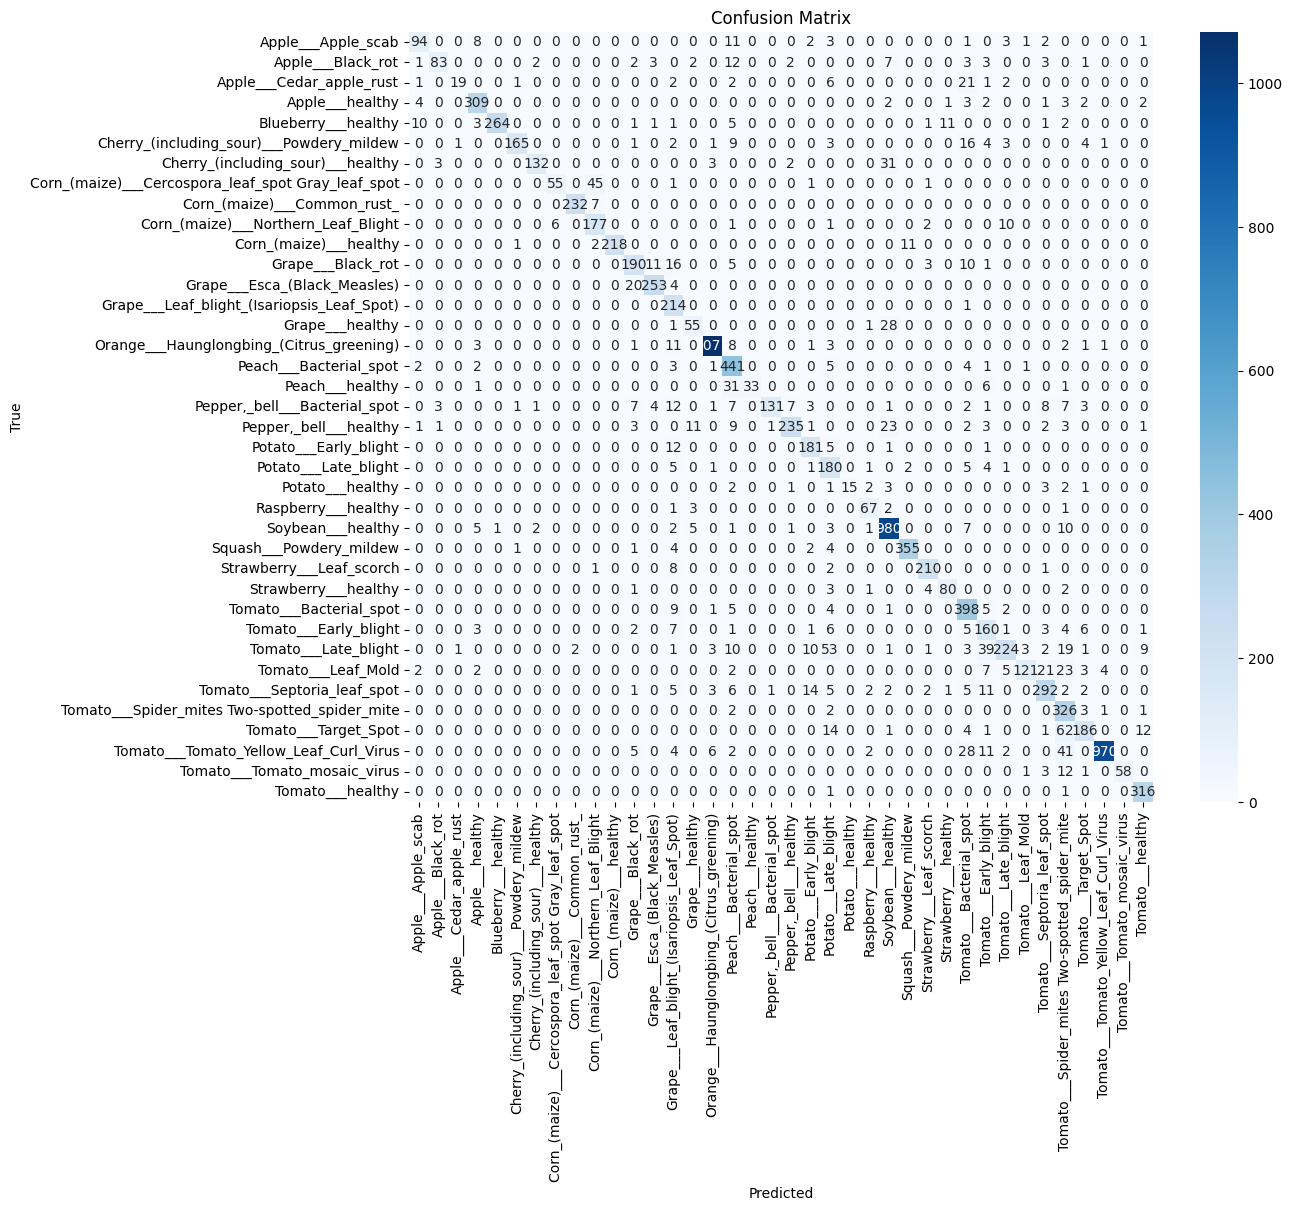

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.82      0.75      0.78       126
                                 Apple___Black_rot       0.92      0.67      0.78       124
                          Apple___Cedar_apple_rust       0.90      0.35      0.50        55
                                   Apple___healthy       0.92      0.94      0.93       329
                               Blueberry___healthy       1.00      0.88      0.93       300
          Cherry_(including_sour)___Powdery_mildew       0.98      0.79      0.87       210
                 Cherry_(including_sour)___healthy       0.96      0.77      0.86       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.90      0.53      0.67       103
                       Corn_(maize)___Common_rust_       0.99      0.97      0.98       239
               Corn_(maize)___Northern_Leaf_Blight       0.76      0.90      0.

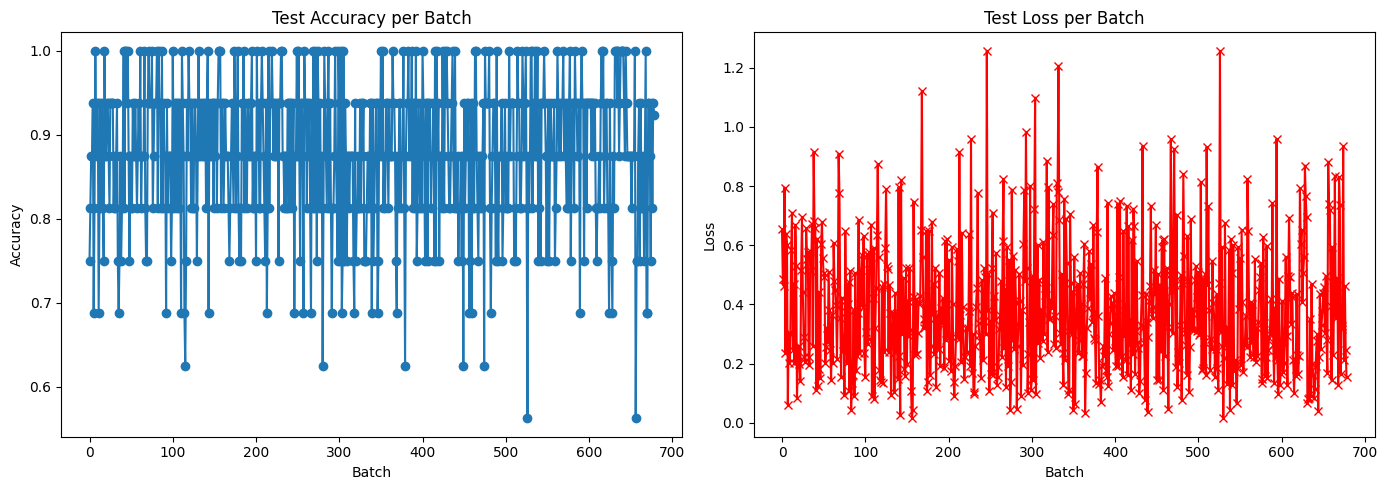

In [ ]:
# Test Accuracy & Loss Plots: Manually track test performance across batches
batch_accuracies = []
batch_losses = []

for images, labels in test_ds:
    loss, acc = model.evaluate(images, labels, verbose=0)
    batch_losses.append(loss)
    batch_accuracies.append(acc)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(batch_accuracies, marker='o')
plt.title('Test Accuracy per Batch')
plt.xlabel('Batch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(batch_losses, marker='x', color='r')
plt.title('Test Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

Processing Image 1: Label = Cherry_(including_sour)___healthy
Processing Image 2: Label = Soybean___healthy
Processing Image 3: Label = Cherry_(including_sour)___healthy
Processing Image 4: Label = Tomato___Tomato_Yellow_Leaf_Curl_Virus
Processing Image 5: Label = Peach___healthy

🖼️ Image 1
✅ Ground Truth: Cherry_(including_sour)___healthy
🔮 Prediction: Cherry_(including_sour)___healthy (27.31%)
🟢 Model prediction is correct.
🎯 Grad-CAM Explanation:
- Brighter red/yellow regions indicate stronger attention.
- These areas likely influenced the model’s decision.


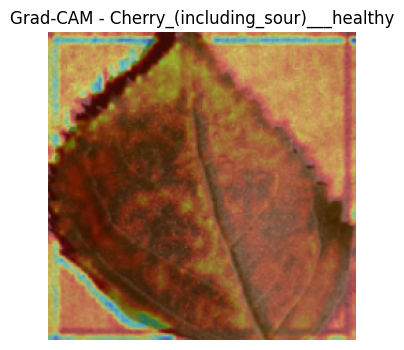


🖼️ Image 2
✅ Ground Truth: Soybean___healthy
🔮 Prediction: Soybean___healthy (99.95%)
🟢 Model prediction is correct.
🎯 Grad-CAM Explanation:
- Brighter red/yellow regions indicate stronger attention.
- These areas likely influenced the model’s decision.


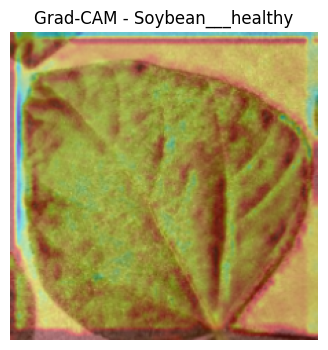


🖼️ Image 3
✅ Ground Truth: Cherry_(including_sour)___healthy
🔮 Prediction: Cherry_(including_sour)___healthy (54.48%)
🟢 Model prediction is correct.
🎯 Grad-CAM Explanation:
- Brighter red/yellow regions indicate stronger attention.
- These areas likely influenced the model’s decision.


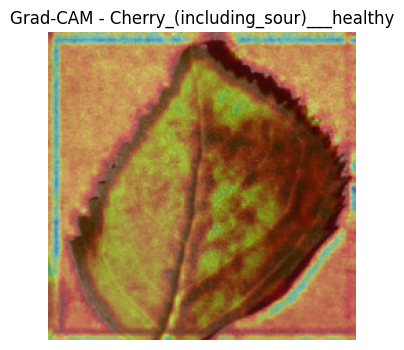


🖼️ Image 4
✅ Ground Truth: Tomato___Tomato_Yellow_Leaf_Curl_Virus
🔮 Prediction: Raspberry___healthy (48.03%)
🔴 Model prediction is incorrect.
🎯 Grad-CAM Explanation:
- Brighter red/yellow regions indicate stronger attention.
- These areas likely influenced the model’s decision.


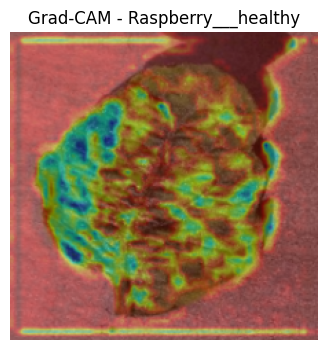


🖼️ Image 5
✅ Ground Truth: Peach___healthy
🔮 Prediction: Peach___healthy (66.77%)
🟢 Model prediction is correct.
🎯 Grad-CAM Explanation:
- Brighter red/yellow regions indicate stronger attention.
- These areas likely influenced the model’s decision.


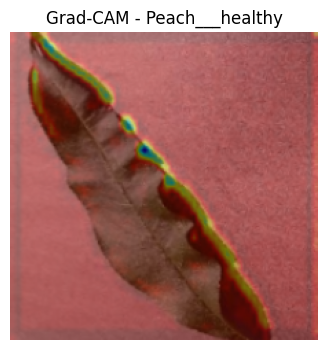

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

# Folder for saving Grad-CAM images
os.makedirs("cnn_gradcam_outputs", exist_ok=True)

# --- Grad-CAM helper functions ---
def make_gradcam_heatmap(img_array, model, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-10)
    return heatmap.numpy(), predictions.numpy()

def display_and_save_gradcam(img, heatmap, file_name, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.uint8(img), 1 - alpha, heatmap_colored, alpha, 0)
    save_path = os.path.join("cnn_gradcam_outputs", file_name)
    cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    return save_path

def explain_gradcam_results(selected_images, selected_labels, predictions, gradcam_paths, class_names):
    index_to_class = dict(enumerate(class_names))
    for idx in range(len(selected_images)):
        image = selected_images[idx].numpy()
        label = selected_labels[idx]
        pred = predictions[idx]
        true_class = index_to_class[label]
        pred_class = index_to_class[np.argmax(pred)]
        confidence = np.max(pred) * 100

        print(f"\n🖼️ Image {idx+1}")
        print(f"✅ Ground Truth: {true_class}")
        print(f"🔮 Prediction: {pred_class} ({confidence:.2f}%)")

        if true_class == pred_class:
            print("🟢 Model prediction is correct.")
        else:
            print("🔴 Model prediction is incorrect.")

        print("🎯 Grad-CAM Explanation:")
        print("- Brighter red/yellow regions indicate stronger attention.")
        print("- These areas likely influenced the model’s decision.")

        plt.figure(figsize=(4, 4))
        cam_img = plt.imread(gradcam_paths[idx])
        plt.imshow(cam_img)
        plt.axis('off')
        plt.title(f"Grad-CAM - {pred_class}")
        plt.show()

# --- Target labels in desired order ---
target_images_info = [
    "Cherry_(including_sour)___healthy",
    "Soybean___healthy",
    "Cherry_(including_sour)___healthy",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Peach___healthy"
]

label_to_index = {name: idx for idx, name in enumerate(class_names)}
target_indices = [label_to_index[label] for label in target_images_info]

found_images = []
found_labels = []

# --- Select exact images in order ---
for target_idx in target_indices:
    for img, lbl in test_ds.unbatch():
        lbl_val = lbl.numpy()
        if lbl_val == target_idx:
            if found_labels.count(lbl_val) < target_images_info.count(class_names[lbl_val]):
                found_images.append(img)
                found_labels.append(lbl_val)
                break

# --- Run Grad-CAM ---
gradcam_paths = []
all_predictions = []

for idx, (img, label) in enumerate(zip(found_images, found_labels)):
    input_array = np.expand_dims(img.numpy(), axis=0)
    heatmap, prediction = make_gradcam_heatmap(input_array, model, 'conv2d_2')  # <- adjust layer if needed
    file_name = f"cnn_gradcam_{idx+1}_{class_names[label]}.png"
    print(f"Processing Image {idx+1}: Label = {class_names[label]}")
    full_path = display_and_save_gradcam(np.uint8(img.numpy() * 255), heatmap, file_name)
    gradcam_paths.append(full_path)
    all_predictions.append(prediction[0])

# --- Display results ---
explain_gradcam_results(found_images, found_labels, all_predictions, gradcam_paths, class_names)
